In [1]:
import pandas as pd
import numpy as np
import numpy.ma as ma
from numpy import trapz
import math
from scipy.stats import norm
from sklearn.feature_selection import f_regression
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble.partial_dependence import plot_partial_dependence
import statsmodels.api as sm
import pickle
from collections import defaultdict
#import feather
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [2]:
with open('./../inds_to_name.pkl','r') as pickleFile:
    inds_to_name = pickle.load(pickleFile)

In [3]:
cats = ['tee3','tee45','green0','green5','green10','green20','rough0','rough90',
        'rough375','fairway0','fairway300','fairway540','bunker']
#cats = ['putting','tee','approach','around_green']

In [4]:
# ranks,reps = {},{}
# for cat in cats:
#     try:
#         ranks[cat] = np.load('./../ranks/ranks-30-0.5-0.1-0.9-0.7-10/%s_ranks.npy' % cat)
#         reps[cat] = np.load('./../ranks/ranks-30-0.5-0.1-0.9-0.7-10/%s_reps.npy' % cat)
#     except:
#         continue

In [5]:
with open('./../hole_tups.pkl','r') as pickleFile:
    hole_tups = pickle.load(pickleFile)

In [6]:
bin_size = 4
window_size = 28
# n_tournament_groups = int(math.ceil(n_tournaments/float(bin_size)))
current_group = 0
tournament_groups = defaultdict(set)
tournaments = set()
group_to_tups = {}
holes_to_inflate = []
for tup in hole_tups:
    tournaments.add(tuple(tup[0:2]))
    tournament_group = (len(tournaments)-1)/bin_size
    if tournament_group>current_group:
        current_group = tournament_group
        group_to_tups[current_group] = holes_to_inflate
        holes_to_inflate = []
    tournament_groups[current_group+1].add(tuple(tup[0:2]))
    holes_to_inflate.append(tuple(tup))

In [7]:
year_inds = [max([[i[0] for i in tournament_groups[j]]]) for j in tournament_groups]
from collections import Counter
year_inds = [Counter(i) for i in year_inds]
year_inds = [sorted(i,key=year_inds[u].get,reverse=True)[0] for u,i in enumerate(year_inds)]
year_inds = np.array(year_inds)
year_inds = [(year,np.argwhere(year_inds==year).min()) for year in range(2003,2017)]

In [16]:
ranks['green0'].shape

(1992, 136)

In [259]:
inds_to_plot

[30]

In [268]:
ranks['rough90'][30,0]

0.58396087743228464

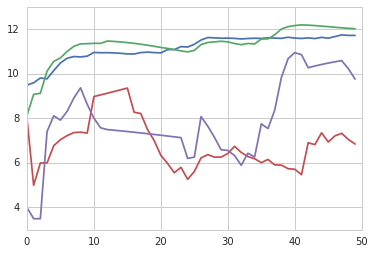

In [288]:
plt.plot(range(reps['rough90'].shape[1])[0:50],[np.log(reps['rough90'][30:32,i]) for i in range(reps['rough90'].shape[1])][0:50])
plt.plot(range(reps['rough90'].shape[1])[0:50],[take_weighted_ave(broadie_opps['rough90'][30:32,:i+1],11) for i in range(reps['rough90'].shape[1])][0:50]);

In [275]:
broadie_opps['rough90'][30,0]

8.0

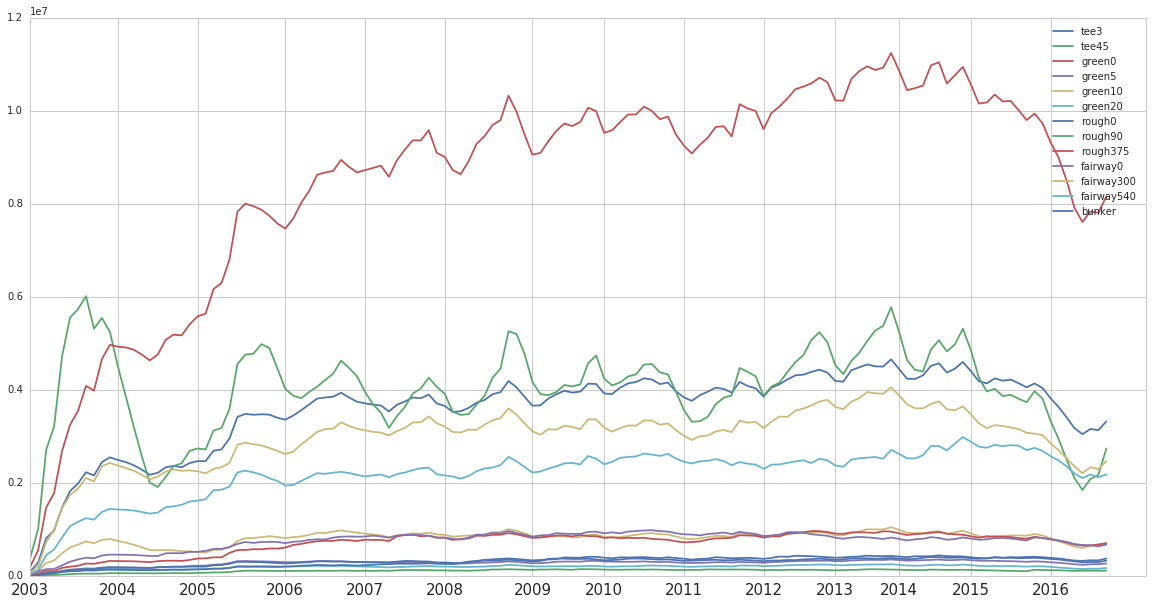

In [276]:
names_to_ind = {value:key for key,value in inds_to_name.iteritems()}
# inds_to_plot = [names_to_ind['Jordan, Spieth'],names_to_ind['Tiger, Woods'],names_to_ind['J.B., Holmes'],
#                 names_to_ind['Phil, Mickelson'],names_to_ind['Dustin, Johnson'],names_to_ind['Jason, Day']]
#inds_to_plot = [names_to_ind['Tiger, Woods'],names_to_ind['Vijay, Singh'],names_to_ind['Jim, Furyk']]#,
                #names_to_ind['Dustin, Johnson'],names_to_ind['Steve, Stricker'],
                #names_to_ind['Jordan, Spieth'], names_to_ind['Jason, Day']]
fig, ax = plt.subplots(figsize=(20, 10))
for cat in cats:
    for j in inds_to_plot:
        #area = trapz(y[np.logical_not(np.isnan(y))], dx=5)
        y = [reps[cat][j,i] for i in range(ranks['green0'].shape[1])]
        plt.plot(y,label = cat);
ax.xaxis.set_ticks([i[1] for i in year_inds])
labels = [i[0] for i in year_inds]
ax.set_xticklabels(labels,fontsize=15);
plt.legend();
# plt.ylim(0.47,.54)

In [11]:
with open('./../num_to_ind.pkl','r') as pickleFile:
    num_to_ind = pickle.load(pickleFile)

In [12]:
data = pd.read_csv('./../data/round.csv')
data.insert(5,'Player_Index',[num_to_ind[num] if num in num_to_ind else np.nan for num in data.Player_Number])
rounds = data.groupby(['Tournament_Year','Permanent_Tournament_#','Round_Number','Course_#'])
n_players = len(num_to_ind)

In [17]:
def take_weighted_ave(A,beta):
    A[np.isnan(A)] = 0
    A_ = ma.array(A)
    A_[A_==0] = ma.masked
    M = np.array([[my_norm(j,beta)]*A.shape[0] for j in range(A.shape[1])[::-1]]).T
    M_ = ma.array(M)
    M_[A_==0] = ma.masked
    return np.array(np.multiply(M_,A_).sum(1)/M_.sum(1))

In [22]:
d = {'Player_Index':[],'Permanent_Tournament_#':[],'Finishing_Pct':[]}
d.update({'Field_Strength_%s' % cat:[] for cat in cats})
d.update({'Rating_%s' % cat:[] for cat in cats})
d.update({'Reps_%s' % cat:[] for cat in cats})
d.update({'Pct_Reps_%s' % cat:[] for cat in cats})
master_df = pd.DataFrame(d)
for j in range(ranks['green0'].shape[1]):
    d = {'rank_%s' % cat: ranks[cat][:,j] for cat in cats}
    d.update({'reps_%s' % cat: take_weighted_ave(broadie_opps[cat][:,:j+1],11) for cat in cats})
    df = pd.DataFrame(d).dropna()
    pct_reps,rank_dict,reps_dict,pct_reps_dict = {},{},{},{}
    for cat in cats:
        pct_reps[cat] = pd.Series(df['reps_%s' % cat][df['reps_%s' % cat]!=0]).rank(pct=True)
        df.insert(len(df.columns),'pct_reps_%s' % cat,[0]*len(df))
        df.ix[df['reps_%s' % cat]!=0,'pct_reps_%s' % cat] = pct_reps[cat]
        rank_dict[cat] = df['rank_%s' % cat].to_dict()
        reps_dict[cat] = df['reps_%s' % cat].to_dict()
        pct_reps_dict[cat] = df['pct_reps_%s' % cat].to_dict()
    mask = np.array([False]*len(data))
    for year,t_id in tournament_groups[j+2]:
        mask = np.logical_or(mask,np.logical_and((data['Tournament_Year']==year).values,(data['Permanent_Tournament_#']==t_id).values))
    df2 = data[mask]
    grouped = df2.groupby(['Player_Index','Permanent_Tournament_#','Tournament_Year'],as_index=False)
    df3 = grouped['Finishing_Pct'].mean()
    assert len(df3)==len(df3.drop_duplicates(['Player_Index','Permanent_Tournament_#','Tournament_Year']))
    for cat in cats:
        df3['Rating_%s' % cat] = df3['Player_Index'].map(rank_dict[cat])
        df3['Reps_%s' % cat] = df3['Player_Index'].map(reps_dict[cat])
        df3['Pct_Reps_%s' % cat] = df3['Player_Index'].map(pct_reps_dict[cat])
    df3 = df3[np.array([df3['Rating_%s' % cat]!=0 for cat in cats]).T.sum(1)==len(cats)].dropna()
    assert len(df3)==len(df3.drop_duplicates(['Player_Index','Permanent_Tournament_#','Tournament_Year']))
    tourn_strength_dict = {}
    tourn_reps_dict = {}
    for cat in cats:
        tourn_strength_dict[cat] = df3.groupby('Permanent_Tournament_#')['Rating_%s' % cat].mean().to_dict()
        df3['Field_Strength_%s' % cat] = df3['Permanent_Tournament_#'].map(tourn_strength_dict[cat])
        tourn_reps_dict[cat] = df3.groupby('Permanent_Tournament_#')['Reps_%s' % cat].mean().to_dict()
        df3['Field_Reps_%s' % cat] = df3['Permanent_Tournament_#'].map(tourn_reps_dict[cat])
    assert len(df3)==len(df3.drop_duplicates(['Player_Index','Permanent_Tournament_#','Tournament_Year']))
    master_df = pd.concat([master_df,df3])

In [23]:
master_df.shape

(67051, 69)

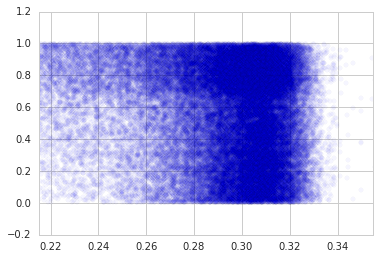

In [351]:
plt.scatter(master_df['Rating_%s' % ('green0',)]-2/master_df['Reps_%s' % ('green0',)]**.5,master_df.Finishing_Pct,alpha=.04);
plt.xlim(.215,.355);

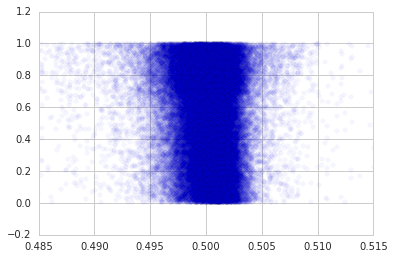

In [24]:
plt.scatter(master_df['Rating_%s' % ('green0',)],master_df.Finishing_Pct,alpha=.04);
plt.xlim(.485,.515);

In [25]:
np.corrcoef(master_df['Rating_%s' % ('green0',)] - 2/master_df['Reps_%s' % ('green0',)]**.5,master_df.Finishing_Pct)

array([[ 1.        , -0.17816825],
       [-0.17816825,  1.        ]])

In [26]:
np.corrcoef(master_df['Rating_%s' % ('green0',)],master_df.Finishing_Pct)

array([[ 1.        , -0.08269754],
       [-0.08269754,  1.        ]])

In [27]:
np.corrcoef(master_df['Rating_%s' % ('green0',)]-master_df['Field_Strength_%s' % ('green0',)],master_df.Finishing_Pct)

array([[ 1.       , -0.0806783],
       [-0.0806783,  1.       ]])

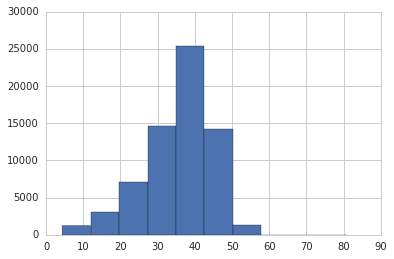

In [44]:
plt.hist(np.array([master_df['Reps_%s' % cat].values for cat in cats]).mean(0));

In [29]:
for cat in cats:
    print cat,np.corrcoef(master_df['Rating_%s' % cat],master_df.Finishing_Pct)[0,1]

tee3 -0.171407432672
tee45 -0.186125498776
green0 -0.0826975444624
green5 -0.0478550461628
green10 -0.0581281228401
green20 -0.0743825310651
rough0 -0.0800324912078
rough90 -0.0721161997167
rough375 -0.13131346373
fairway0 -0.100057680956
fairway300 -0.162904000134
fairway540 -0.150738279056
bunker -0.0901675191897


In [28]:
for cat in cats:
    print cat,np.corrcoef(master_df['Rating_%s' % cat] - 2/master_df['Reps_%s' % cat]**.5,master_df.Finishing_Pct)[0,1]

tee3 -0.190462473635
tee45 -0.199171069278
green0 -0.178168254953
green5 -0.170927810981
green10 -0.176683281314
green20 -0.171551887956
rough0 -0.158720333302
rough90 -0.129922783007
rough375 -0.149921197897
fairway0 -0.13229420044
fairway300 -0.179680185193
fairway540 -0.149249969464
bunker -0.148493428402


In [301]:
print np.corrcoef(master_df[['Reps_%s' % cat for cat in cats]].values.mean(1),master_df.Finishing_Pct)[0,1]
print np.corrcoef(master_df_broadie[['Reps_%s' % cat for cat in cats]].values.mean(1),master_df_broadie.Finishing_Pct)[0,1]

-0.172323878723
-0.172393219056


In [302]:
train = (master_df.Tournament_Year<2013).values

In [355]:
#X_lab = np.array(cats)[np.argsort([np.corrcoef(master_df['Rating_%s' % cat],master_df.Finishing_Pct)[0,1] for cat in cats])]
X = master_df[['Rating_%s' % (cat,) for cat in cats]].values - 5/master_df[['Reps_%s' % (cat,) for cat in cats]].values**.5
- (master_df[['Field_Strength_%s' % (cat,) for cat in cats]].values - 5/master_df[['Field_Reps_%s' % (cat,) for cat in cats]].values**.5)
X = np.hstack((X,(master_df[['Reps_%s' % cat for cat in cats]].values.mean(1)-master_df[['Field_Reps_%s' % (cat,) for cat in cats]].values.mean(1))[:,None]))
X = sm.add_constant(X)

In [356]:
y = master_df.Finishing_Pct.values

In [357]:
X_train,X_test,y_train,y_test = X[train],X[~train],y[train],y[~train]

In [358]:
X_train = pd.DataFrame(X_train)
X_train.columns = ['coef']+cats+['reps']
model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
results = model.fit()

In [341]:
# feather.write_dataframe(X, './../adam_df.feather')

In [359]:
to_predict = set(tuple(tup) for tup in master_df[['Permanent_Tournament_#','Player_Index','Tournament_Year']].values.tolist())

In [58]:
mat = dict()
for tourn,df in master_df.groupby('Permanent_Tournament_#'):
    for cat in cats:
        if cat not in mat:
            mat[cat] = []
        mat[cat].extend(df['Rating_' + cat].rank(pct=True).values.tolist())

In [63]:
df = pd.DataFrame(mat)
df.columns = cats

In [68]:
import seaborn as sns

In [75]:
np.cov(df.values.T)[3,:]

array([ -3.03073938e-03,  -9.05182975e-04,   1.15499101e-02,
         8.33345913e-02,  -6.58709119e-03,  -5.06247969e-03,
        -5.38010715e-03,  -9.09643891e-03,  -4.00940406e-03,
         2.34828308e-02,  -6.17706219e-05,   2.46578343e-02,
         4.26015497e-02])

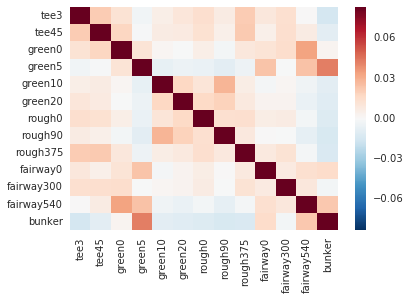

In [70]:
sns.heatmap(np.cov(df.values.T), 
            xticklabels=df.columns.values,
            yticklabels=df.columns.values)

In [360]:
print results.summary()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                49301
Model:                            GLM   Df Residuals:                    49286
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -33177.
Date:                Wed, 19 Oct 2016   Deviance:                       83887.
Time:                        07:03:02   Pearson chi2:                 1.67e+04
No. Iterations:                     8                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
coef           1.8331      0.222      8.275      0.000         1.399     2.267
tee3          -2.7859      0.468     -5.952      0.0

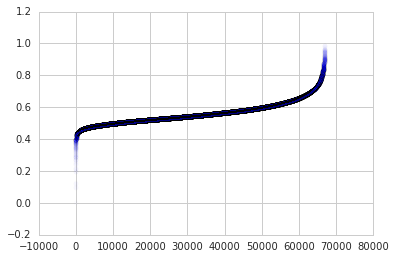

In [361]:
plt.scatter(range(len(master_df)),np.sort(results.predict(X)),alpha=.01);

In [362]:
np.mean((results.predict(X_test)-y_test)**2)

0.081355917689421339

In [ ]:
np.corrcoef((results.predict(X_test)-y_test)**2,X_test[:,-1])

In [210]:
gbr = GradientBoostingRegressor(loss='ls', learning_rate=0.01, n_estimators=10750, subsample=.5,
                                min_samples_split=2, min_samples_leaf=1, max_depth=3, max_features=4, verbose=0)

In [176]:
def make_monitor(running_mean_len):
    def monitor(i,self,args):
        if np.mean(self.oob_improvement_[max(0,i-running_mean_len+1):i+1])<0:
            return True
        else:
            return False
    return monitor

In [177]:
errors = []
num_estimators = []
stopping_num = range(1,10000,200)
for running_mean_len in stopping_num:
    monitor = make_monitor(running_mean_len)
    gbr.fit(X_train,y_train,monitor=monitor)
    num_estimators.append(gbr.estimators_.shape[0])
    print running_mean_len,gbr.estimators_.shape[0]
    errors.append(np.mean((gbr.predict(X_test) - y_test)**2))

1 581
201 960
401 1105
601 1219
801 1354
1001 1527
1201 1701
1401 1852
1601 2042
1801 2211
2001 2379
2201 2559
2401 2743
2601 2931
2801 3109
3001 3292
3201 3474
3401 3658
3601 3854
3801 4039
4001 4234
4201 4417
4401 4613
4601 4801
4801 4992
5001 5185
5201 5379
5401 5570


KeyboardInterrupt: 

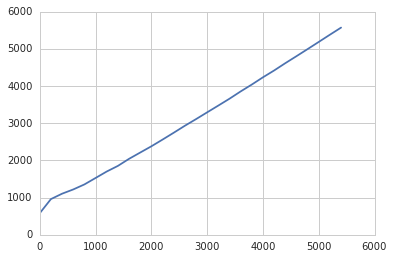

In [182]:
plt.plot(stopping_num[:len(num_estimators)],num_estimators);

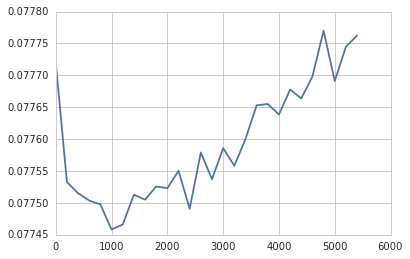

In [183]:
plt.plot(stopping_num[:len(num_estimators)],errors);

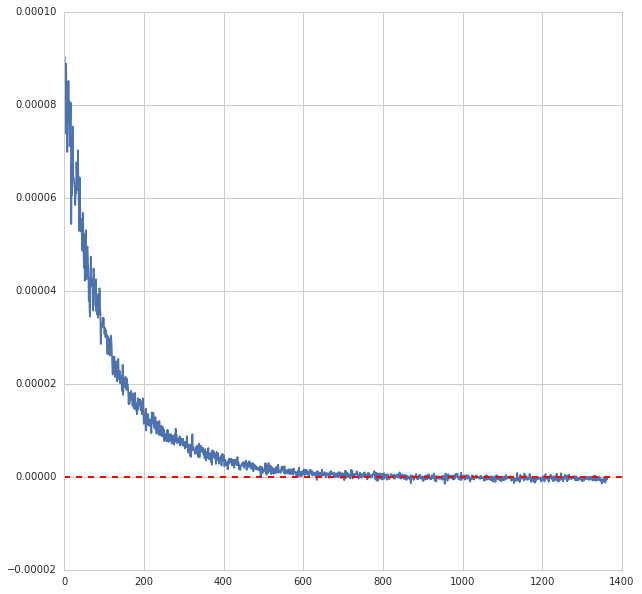

In [142]:
plt.figure(figsize=(10,10))
plt.plot(range(gbr.estimators_.shape[0]),gbr.oob_improvement_)
plt.axhline(0,lw=2,ls='--',c='r');

In [367]:
gbr.feature_importances_

array([ 0.        ,  0.07146322,  0.13448892,  0.07113536,  0.06119007,
        0.05346792,  0.06931811,  0.06193378,  0.05169413,  0.05898009,
        0.06518256,  0.07963229,  0.06473562,  0.06437245,  0.09240547])

In [107]:
gbr.feature_importances_

array([ 0.0725219 ,  0.15250034,  0.07578977,  0.05040343,  0.05901873,
        0.05793608,  0.05446399,  0.04623043,  0.05986364,  0.06656072,
        0.08813654,  0.06569206,  0.06806106,  0.0828213 ])

In [364]:
X_train.reps.describe()

count    4.930100e+04
mean     9.944514e-18
std      8.673659e+00
min     -3.343965e+01
25%     -5.140430e+00
50%      1.087862e+00
75%      6.264481e+00
max      4.566747e+01
Name: reps, dtype: float64

In [382]:
gbr.predict(np.array([1,0,0,0,0,0,0,0,0,0,0,0,0,0,4]).reshape(1, -1))

array([ 0.64495005])

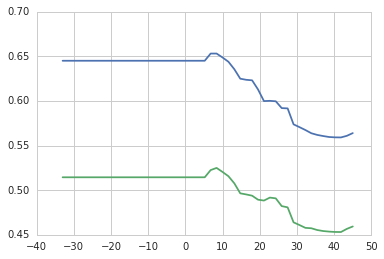

In [406]:
plt.plot(np.linspace(-33,45,50),[gbr.predict(np.array([1,0,0,0,0,0,0,0,0,0,0,0,0,0,i]).reshape(1, -1)) for i in np.linspace(-33,45,50)])
plt.plot(np.linspace(-33,45,50),[gbr.predict(np.array([1,.02,0,0,0,0,0,0,0,0,0,0,.9,0,i]).reshape(1, -1)) for i in np.linspace(-33,45,50)])

In [108]:
X_train.shape

(49302, 14)

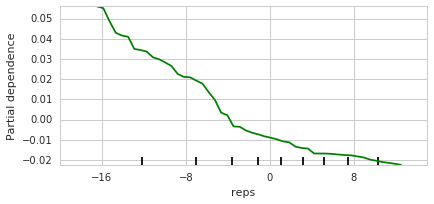

In [109]:
fig,axs = plot_partial_dependence(gbr,X_train,[13],feature_names=np.array(cats+['reps']),n_jobs=1,grid_resolution=50)

In [143]:
labels = cats+['reps']
d = {label:imp for label,imp in zip(labels,gbr.feature_importances_)}
for label in sorted(d,key=d.get,reverse=True):
    print label,d[label]

tee45 0.134412039951
fairway300 0.0885320975991
reps 0.086126150181
green0 0.0720100986657
bunker 0.0701578316389
tee3 0.0675986856816
fairway540 0.0675510998702
fairway0 0.0671178711547
rough375 0.0635953231172
green20 0.0617963728761
green10 0.0593038881548
rough0 0.0579851226685
green5 0.0534797087892
rough90 0.0503337096524


In [144]:
np.mean((gbr.predict(X_test)-y_test)**2)

0.077447001074113633

In [149]:
master_df.shape

(59950, 31)

In [150]:
X.shape

(67053, 14)

In [170]:
master_df.insert(len(master_df.columns),'Predicted_Finishing_Pct',gbr.predict(X))
# master_df.insert(len(master_df.columns),'Var_of_Pred_Finishing_Pct',1/w)
master_df.insert(len(master_df.columns),'Player_Name',[inds_to_name[ind] for ind in master_df.Player_Index])
master_df = master_df.reset_index()

In [171]:
master_df.insert(len(master_df.columns),'Squared_Error',
                 (master_df.Predicted_Finishing_Pct - master_df.Finishing_Pct)**2)

In [172]:
master_df.insert(len(master_df.columns),'Ave_Reps',master_df[['Reps_%s' % cat for cat in cats]].values.mean(1))

In [173]:
master_df.sort_values('Predicted_Finishing_Pct',ascending=True)[['Player_Name','Player_Index','Predicted_Finishing_Pct',
                                                                 'Finishing_Pct','Tournament_Year']].head(10)

,Player_Name,Player_Index,Predicted_Finishing_Pct,Finishing_Pct,Tournament_Year
7597,"Vijay, Singh",80,0.131173,0.045964,2004
2663,"Tiger, Woods",78,0.135565,0.028539,2003
4936,"Vijay, Singh",80,0.142302,0.004153,2004
3162,"Vijay, Singh",80,0.147300,0.051907,2003
2146,"Vijay, Singh",80,0.151530,0.095291,2003
2145,"Vijay, Singh",80,0.154582,0.168502,2003
8644,"Vijay, Singh",80,0.154647,0.005531,2004
6548,"Tiger, Woods",78,0.155896,0.039700,2004
10065,"Vijay, Singh",80,0.156492,0.229167,2005
13244,"Tiger, Woods",78,0.162197,0.018162,2005


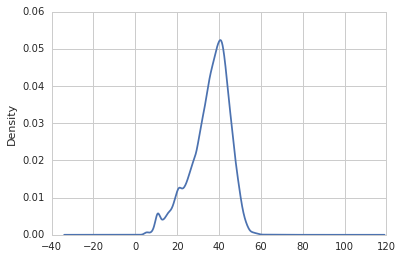

In [51]:
master_df.Ave_Reps.plot(kind='kde');

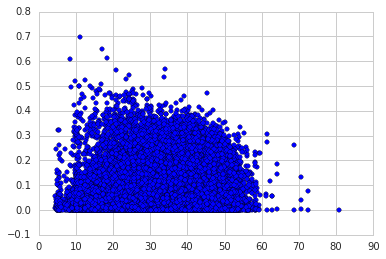

In [62]:
plt.scatter(master_df.Ave_Reps.values,master_df.Squared_Error);

In [116]:
np.corrcoef(master_df.Ave_Reps.values,master_df.Squared_Error)[0,1]

0.085064495886594427

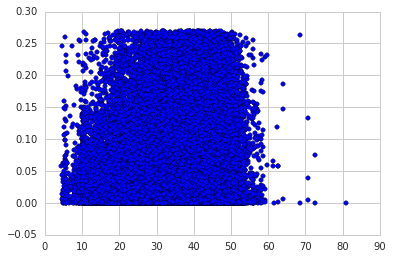

In [57]:
plt.scatter(master_df[master_df.Squared_Error<.27].Ave_Reps.values,master_df[master_df.Squared_Error<.27].Squared_Error);

In [56]:
np.corrcoef(master_df[master_df.Squared_Error<.27].Ave_Reps.values,master_df[master_df.Squared_Error<.27].Squared_Error)[0,1]

0.13602986865048541

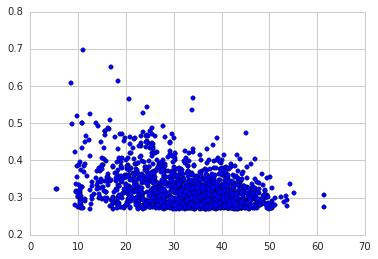

In [58]:
plt.scatter(master_df[master_df.Squared_Error>.27].Ave_Reps.values,master_df[master_df.Squared_Error>.27].Squared_Error);

In [59]:
(master_df.Squared_Error>.27).sum()

1543

In [55]:
np.corrcoef(master_df[master_df.Squared_Error>.27].Ave_Reps.values,master_df[master_df.Squared_Error>.27].Squared_Error)[0,1]

-0.36416576218530516

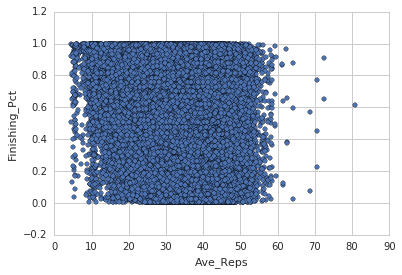

In [64]:
master_df.plot('Ave_Reps','Finishing_Pct',kind='scatter');
#plt.xlim(-.05,1)

In [61]:
np.corrcoef(master_df.Ave_Reps.values,master_df.Finishing_Pct)[0,1]

-0.17267547172472653

Broadie aves

In [21]:
broadie_cats = cats#['Putting','Off-the-Tee','Approach-the-Green','Around-the-Green']

In [20]:
broadie_aves,broadie_opps = {},{}
for cat in cats:
    broadie_aves[cat] = np.load('./../Broadie_aveso/%s_ave.npy' % cat)
    broadie_opps[cat] = np.load('./../Broadie_aveso/%s_count.npy' % cat)

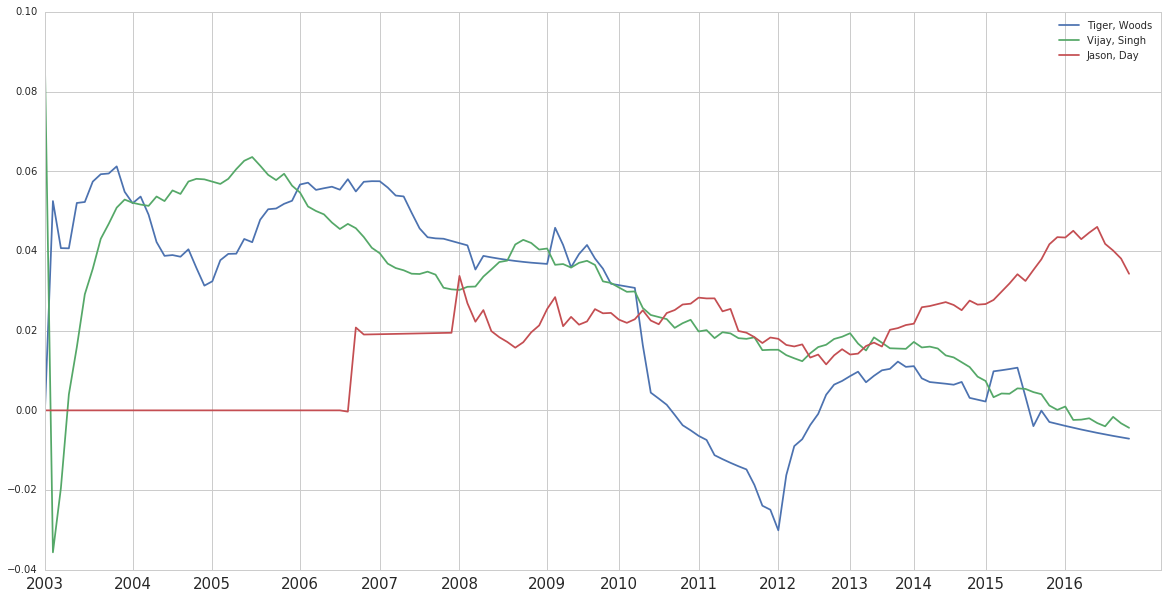

In [203]:
names_to_ind = {value:key for key,value in inds_to_name.iteritems()}
# inds_to_plot = [names_to_ind['Vijay, Singh'],names_to_ind['Tiger, Woods'],names_to_ind['Luke, Donald'],
#                 names_to_ind['Phil, Mickelson'],names_to_ind['Steve, Stricker'],names_to_ind['Jim, Furyk']]
inds_to_plot = [names_to_ind['Tiger, Woods'],names_to_ind['Vijay, Singh'],names_to_ind['Jason, Day']]#,
                #names_to_ind['Dustin, Johnson'],names_to_ind['Steve, Stricker'],
                #names_to_ind['Jordan, Spieth'], names_to_ind['Jason, Day']]
fig, ax = plt.subplots(figsize=(20, 10))
for j in inds_to_plot:
    #area = trapz(y[np.logical_not(np.isnan(y))], dx=5)
    y = [ra[i][j] for i in range(broadie_aves['green0'].shape[1])]
    plt.plot(y,label = inds_to_name[j]);
ax.xaxis.set_ticks([i[1] for i in year_inds])
labels = [i[0] for i in year_inds]
ax.set_xticklabels(labels,fontsize=15);
plt.legend();
#plt.ylim(-.015,.025);

In [19]:
def my_norm(x,BETA):
    return norm.pdf(x,0,BETA)/norm.pdf(0,0,BETA)

In [195]:
beta = 11
d = {'Player_Index':[],'Permanent_Tournament_#':[],'Finishing_Pct':[]}
d.update({'Field_Strength_%s' % cat:[] for cat in broadie_cats})
d.update({'Rating_%s' % cat:[] for cat in broadie_cats})
d.update({'Reps_%s' % cat:[] for cat in broadie_cats})
d.update({'Pct_Reps_%s' % cat:[] for cat in broadie_cats})
master_df_broadie = pd.DataFrame(d)
broadie_ranks,broadie_reps = {},{}
ra,re = [],[]
for j in range(broadie_aves['green0'].shape[1]):
    for cat in broadie_cats:
        if cat not in broadie_ranks:
            broadie_ranks[cat],broadie_reps[cat] = None,None
        broadie_ranks[cat] = take_weighted_ave(broadie_aves[cat][:,:j+1],beta)
        broadie_reps[cat] = take_weighted_ave(broadie_opps[cat][:,:j+1],beta)
        if cat=='tee45':
            ra.append(broadie_ranks[cat])
            re.append(broadie_reps[cat])
    d = {'rank_%s' % cat: broadie_ranks[cat] for cat in broadie_cats}
    d.update({'reps_%s' % cat: broadie_reps[cat] for cat in broadie_cats})
    df = pd.DataFrame(d).dropna()
    pct_reps,rank_dict,reps_dict,pct_reps_dict = {},{},{},{}
    for cat in broadie_cats:
        pct_reps[cat] = pd.Series(df['reps_%s' % cat][df['reps_%s' % cat]!=0]).rank(pct=True)
        df.insert(len(df.columns),'pct_reps_%s' % cat,[0]*len(df))
        df.ix[df['reps_%s' % cat]!=0,'pct_reps_%s' % cat] = pct_reps[cat]
        rank_dict[cat] = df['rank_%s' % cat].to_dict()
        reps_dict[cat] = df['reps_%s' % cat].to_dict()
        pct_reps_dict[cat] = df['pct_reps_%s' % cat].to_dict()
    mask = np.array([False]*len(data))
    for year,t_id in tournament_groups[j+2]:
        mask = np.logical_or(mask,np.logical_and((data['Tournament_Year']==year).values,(data['Permanent_Tournament_#']==t_id).values))
    df2 = data[mask]
    grouped = df2.groupby(['Player_Index','Permanent_Tournament_#','Tournament_Year'],as_index=False)
    df3 = grouped['Finishing_Pct'].mean()
    for cat in broadie_cats:
        df3['Rating_%s' % cat] = df3['Player_Index'].map(rank_dict[cat])
        df3['Reps_%s' % cat] = df3['Player_Index'].map(reps_dict[cat])
        df3['Pct_Reps_%s' % cat] = df3['Player_Index'].map(pct_reps_dict[cat])
    df3 = df3[np.array([df3['Rating_%s' % cat]!=0 for cat in broadie_cats]).T.sum(1)==len(cats)].dropna()
    tourn_strength_dict = {}
    for cat in broadie_cats:
        tourn_strength_dict[cat] = df3.groupby('Permanent_Tournament_#')['Rating_%s' % cat].mean().to_dict()
        df3['Field_Strength_%s' % cat] = df3['Permanent_Tournament_#'].map(tourn_strength_dict[cat])
    master_df_broadie = pd.concat([master_df_broadie,df3])

In [ ]:
# errors = []
# for beta in np.arange(3,15,1):
#     errors.append(run(beta))

In [ ]:
plt.plot(np.arange(3,15,1),errors);

In [ ]:
np.arange(3,15,1)[np.argsort(errors)[0]]

In [199]:
isin = [tuple(tup) in to_predict for tup in master_df_broadie[['Permanent_Tournament_#','Player_Index','Tournament_Year']].values.tolist()]

In [200]:
master_df_broadie = master_df_broadie[isin]

In [205]:
X = master_df_broadie[['Rating_%s' % (cat,) for cat in broadie_cats]].values - master_df_broadie[['Field_Strength_%s' % (cat,) for cat in broadie_cats]].values
X = np.hstack((X,master_df_broadie[['Reps_%s' % cat for cat in broadie_cats]].values.mean(1)[:,None]))
X = sm.add_constant(X)
y = master_df_broadie.Finishing_Pct.values

In [206]:
train = (master_df_broadie.Tournament_Year<2013).values

In [207]:
X_train,X_test,y_train,y_test = X[train],X[~train],y[train],y[~train]

In [211]:
monitor = make_monitor(1000)
gbr.fit(X_train,y_train,monitor=monitor)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.01, loss='ls',
             max_depth=3, max_features=4, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10750,
             presort='auto', random_state=None, subsample=0.5, verbose=0,
             warm_start=False)

In [212]:
np.mean((gbr.predict(X_test)-y_test)**2)

0.077618360275086784

In [ ]:
X_train = pd.DataFrame(X_train)
X_train.columns = ['coef']+broadie_cats+['reps']
model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
results = model.fit()

In [ ]:
# feather.write_dataframe(X, './../broadie_df.feather')

In [ ]:
print results.summary()

In [ ]:
np.mean((results.predict(X_test)-y_test)**2)

In [ ]:
np.corrcoef((results.predict(X_test)-y_test)**2,X_test[:,-1])

In [410]:
improve = []
for cat in cats:
    a = np.corrcoef(master_df['Rating_%s' % cat],master_df.Finishing_Pct)[0,1]
    b = np.corrcoef(master_df_broadie['Rating_%s' % cat],master_df_broadie.Finishing_Pct)[0,1]
    print cat,a,b
    improve.append(b-a)

tee3 -0.171052580311 -0.146032538025
tee45 -0.186125498776 -0.164844915209
green0 -0.0827043407964 -0.0677804930683
green5 -0.0478550461628 -0.0456927938935
green10 -0.0581281228401 -0.0525675865471
green20 -0.0743825310651 -0.0735202164822
rough0 -0.0800324912078 -0.0679230431509
rough90 -0.0721161997167 -0.0630958094282
rough375 -0.130797804764 -0.119180384468
fairway0 -0.0998994960999 -0.0885873314073
fairway300 -0.162533546282 -0.1456878488
fairway540 -0.15007665597 -0.13184067287
bunker -0.0899071323976 -0.078778176547


In [ ]:
# master_df.to_csv('master_df.csv',index=False)
# master_df_broadie.to_csv('master_df_broadie',index=False)

In [411]:
np.mean(improve)

0.012313818191633675

In [14]:
ranks = {}
scores = {}
for (_, dirnames, _) in os.walk('./../ranks/'):
    for dirname in dirnames:
        for cat in cats:
            try:
                ranks[cat] = np.load('./../ranks/'+dirname+'/%s_ranks.npy' % (cat,))
            except:
                break
        if cat!='bunker':
            continue
        d = {'Player_Index':[],'Permanent_Tournament_#':[],'Course_#':[],'Finishing_Pct':[]}
        d.update({'Field_Strength_%s' % cat:[] for cat in cats})
        d.update({'Rating_%s' % cat:[] for cat in cats})
        master_df = pd.DataFrame(d)
        for j in range(ranks['green0'].shape[1]):
            d = {'rank_%s' % cat: ranks[cat][:,j] for cat in cats}
            df = pd.DataFrame(d).dropna()
            rank_dict = {}
            for cat in cats:
                rank_dict[cat] = df['rank_%s' % cat].to_dict()
            mask = np.array([False]*len(data))
            for year,t_id in tournament_groups[j+2]:
                mask = np.logical_or(mask,np.logical_and((data['Tournament_Year']==year).values,(data['Permanent_Tournament_#']==t_id).values))
            df2 = data[mask]
            grouped = df2.groupby(['Player_Index','Permanent_Tournament_#','Course_#','Tournament_Year'],as_index=False)
            df3 = grouped['Finishing_Pct'].mean()
            for cat in cats:
                df3['Rating_%s' % cat] = df3['Player_Index'].map(rank_dict[cat])
            df3 = df3[np.array([df3['Rating_%s' % cat]!=0 for cat in cats]).T.sum(1)==len(cats)].dropna()
            tourn_strength_dict = {}
            for cat in cats:
                tourn_strength_dict[cat] = df3.groupby('Permanent_Tournament_#')['Rating_%s' % cat].mean().to_dict()
                df3['Field_Strength_%s' % cat] = df3['Permanent_Tournament_#'].map(tourn_strength_dict[cat])
            master_df = pd.concat([master_df,df3])
        master_df = master_df[master_df.Tournament_Year<2013]
        scores[dirname] = {}
        for cat in cats:
            scores[dirname][cat] = np.corrcoef(master_df['Rating_%s' % cat],master_df.Finishing_Pct)[0,1]

In [15]:
ranks,reps = {},{}
for cat in cats:
    print cat
    d = {key:scores[key][cat] for key in scores.keys()}
    for key in sorted(d,key=d.get)[0:7]:
        print key,d[key]
    best = sorted(d,key=d.get)[0]
    ranks[cat] = np.load('./../ranks/'+best+'/%s_ranks.npy' % (cat,))
    reps[cat] = np.load('./../ranks/'+best+'/%s_reps.npy' % (cat,))

tee3
ranks-300-0.01-0.15-0.3-0.99-13 -0.16396774099
ranks-300-0.01-0.01-0.3-0.99-13 -0.163647171391
ranks-300-0.01-0.01-0.7-0.99-13 -0.163632861683
ranks-300-0.01-0.01-0.95-0.99-13 -0.16362401487
ranks-150-0.5-0.25-0.8-0.95-12 -0.163517821624
ranks-300-0.01-0.15-0.3-0.99-17 -0.163458582669
ranks-90-0.7-0.25-0.8-0.93-12 -0.163370108581
tee45
ranks-300-0.01-0.15-0.3-0.99-5 -0.176365056402
ranks-300-0.01-0.01-0.3-0.99-5 -0.176155396279
ranks-300-0.01-0.01-0.7-0.99-5 -0.17614556336
ranks-300-0.01-0.01-0.95-0.99-5 -0.176139526431
ranks-300-0.01-0.15-0.3-0.93-5 -0.174206267468
ranks-300-0.01-0.15-0.7-0.93-5 -0.174105664542
ranks-300-0.01-0.01-0.3-0.93-5 -0.174038579435
green0
ranks-300-0.01-0.15-0.3-0.99-17 -0.0905062630757
ranks-300-0.01-0.01-0.3-0.99-17 -0.0904831822112
ranks-300-0.01-0.01-0.7-0.99-17 -0.0904781797849
ranks-300-0.01-0.01-0.95-0.99-17 -0.0904749893737
ranks-300-0.01-0.15-0.3-0.99-13 -0.090451026182
ranks-300-0.01-0.01-0.3-0.99-13 -0.0904008858706
ranks-300-0.01-0.01-0.7-0.9

In [ ]:
corrs=defaultdict(list)
for year in range(2003,2017):
    d = {'Player_Index':[],'Permanent_Tournament_#':[],'Course_#':[],'Finishing_Pct':[]}
    d.update({'Field_Strength_%s' % cat:[] for cat in cats})
    d.update({'Rating_%s' % cat:[] for cat in cats})
    master_df = pd.DataFrame(d)
    for j in range(ranks['green0'].shape[1]):
        d = {'rank_%s' % cat: ranks[cat][:,j] for cat in cats}
        df = pd.DataFrame(d).dropna()
        rank_dict = {}
        for cat in cats:
            rank_dict[cat] = df['rank_%s' % cat].to_dict()
        years = [i[0] for i in tournament_groups[j+2]]
        t_ids = [i[1] for i in tournament_groups[j+2]]
        df2 = data[data['Tournament_Year'].isin(years) & data['Permanent_Tournament_#'].isin(t_ids)]
        grouped = df2.groupby(['Player_Index','Permanent_Tournament_#','Course_#','Tournament_Year'],as_index=False)
        df3 = grouped['Finishing_Pct'].mean()
        for cat in cats:
            df3['Rating_%s' % cat] = df3['Player_Index'].map(rank_dict[cat])
        df3 = df3[np.array([df3['Rating_%s' % cat]!=0 for cat in cats]).T.sum(1)==len(cats)].dropna()
        tourn_strength_dict = {}
        for cat in cats:
            tourn_strength_dict[cat] = df3.groupby('Permanent_Tournament_#')['Rating_%s' % cat].mean().to_dict()
            df3['Field_Strength_%s' % cat] = df3['Permanent_Tournament_#'].map(tourn_strength_dict[cat])
        master_df = pd.concat([master_df,df3])
    master_df = master_df[master_df.Tournament_Year==year]
    for cat in cats:
        corrs[cat].append(np.corrcoef(master_df['Rating_%s' % (cat,)].values - master_df['Field_Strength_%s' % (cat,)].values,\
                          master_df.Finishing_Pct)[0,1])

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
for cat in cats:
    plt.plot(range(2003,2017),corrs[cat],label=cat)
plt.legend();

In [ ]:
def make_natural_spline_matrix(x,df):
    t = np.percentile(x,np.linspace(0,100,df+2)[1:-1])
    print t
    X = np.column_stack(([1.0]*len(x),x))
    def d(x,e_k,e_K):
        def pos(x,e):
            x_ = np.copy(x)
            x_[x<=e] = 0.0
            x_[x>e] = (x_[x>e]-e)**3
            return x_
        return (pos(np.copy(x),e_k) - pos(np.copy(x),e_K))/(e_K-e_k)
    for k in range(1,len(t)-1):
        X = np.column_stack((X,d(np.copy(x),t[k],t[-1]) - d(np.copy(x),t[k-1],t[-1])))
    return X